# plotting hovmoller for mangroves

In [1]:
#in this notebook we want to plot non-interactively
%matplotlib inline

#get standard libraries
import datetime as dt
import fiona
import geopandas as gpd
import shapely.geometry
from shapely.geometry import shape
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib import colors
from matplotlib import pyplot as plt
import matplotlib.dates
import numpy as np
import os
import pickle
import rasterio
import rasterio.features
import sys
import xarray as xr

#modules for datacube
import datacube
from datacube.utils import geometry
from datacube.drivers.netcdf import write_dataset_to_netcdf
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('/home/jovyan/Scripts/'))
import dea_plotting, dea_datahandling

#Emma - I added this bit it in as cloud free landsat scenes are now obtained a different way
sys.path.insert(1, '/home/jovyan/Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

#alias for datacube
dc = datacube.Datacube(app='dc-BoMrainfallandNbart')


In [2]:
#This defines the function that converts a linear vector file into a string of x,y coordinates
def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }

def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))

In [3]:
#transects file will be the file containing our transects
transects_file = '/home/jovyan/WA1.shp'
transects_df = gpd.read_file(transects_file)
transects_df.crs

#need to be WGS84 coordinate system for transects as it assumes this system

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
#Define temporal range
start_of_epoch = '2016-01-01' 
end_of_epoch =  '2020-12-31'
print ('temporal range is '+start_of_epoch+' to '+end_of_epoch)

temporal range is 2016-01-01 to 2020-12-31


In [5]:
#use fiona module to open the shape file
transects = fiona.open(transects_file)

#this statement asks you to choose a shapefile. put in a number and press enter.
i = int(input("choose the index of the transect you would like to plot:"))
#for i in range(len(transects)):

geom1 = shape(transects[i]['geometry'])
geom_query1 = geom_query(geom1)
query = {
    'time': (start_of_epoch, end_of_epoch),  
}
query.update(geom_query(geom1, geom_crs=transects.crs_wkt)) 

choose the index of the transect you would like to plot: 0


In [6]:
#use the transect dataframe to get transect metadata
transect_index = transects_df.index[i]
transect_name = transects_df['Name'][i] 
try:
    print(transect_name)
except TypeError as err:
    print("TypeError: {0}".format(err))
    print(transect_name)

#create a filename for the transect
shape_name = transect_name.split()
shape_name ='_'.join(shape_name)
shape_name=shape_name+'_ix'+str(transect_index)
print(shape_name)

#setup a save directory for our data
savepath ='./'+shape_name+'_/'
try:
        os.mkdir(savepath)
except OSError as err:
        print("OS error: {0}".format(err))

WA1
WA1_ix0
OS error: [Errno 17] File exists: './WA1_ix0_/'


In [7]:
print(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl')

./WA1_ix0_/hov_data_WA1_ix0_2016-01-01_2020-12-31.pkl


In [8]:
#use our DEADataHandling function to load landsat data for all sensors in epoch and mask out cloudy scenes
ds = dea_datahandling.load_ard(dc=dc, products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],min_gooddata=0.99, output_crs='EPSG:3577',
          resolution=(-30, 30),**query)
print('loaded SR data from DEA, loading rainfall data')

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 125 out of 369 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 125 time steps
loaded SR data from DEA, loading rainfall data


In [9]:
#This controls the colour map used for plotting NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
#Be aware that clip = True might be causing issues
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N, clip=True)

In [10]:
## Compress 
ds.crs
crs = ds.crs
crs_wkt = ds.crs
geom_w = warp_geometry(geom1, query['crs'], crs_wkt)
# hov_ds= transect(ds, geom_w, 25)   

In [11]:
# hov_multi_ndvi = ((ds_masked.nbart_nir-ds_masked.nbart_red)/(ds_masked.nbart_nir+ds_masked.nbart_red))
hov_multi_ndvi = ((ds.nbart_nir-ds.nbart_red)/(ds.nbart_nir+ds.nbart_red))


In [12]:
dist = [i for i in range(0, int(geom_w.length), 30)]
#points = zip(*[geom.interpolate(d).coords[0] for d in dist]) py2
points = list(zip(*[geom_w.interpolate(d).coords[0] for d in dist])) #py3


In [13]:
y_dim = np.asarray(points[1])
x_dim = np.asarray(points[0])
hov_multi_ndvi_sel = hov_multi_ndvi.sel(x=xr.DataArray(x_dim, dims='distance'),
                                              y=xr.DataArray(y_dim, dims='distance'), 
                                              method='nearest')

In [22]:
hov_multi_ndvi_sel.distance * 30

<xarray.DataArray 'distance' (distance: 41)>
array([   0,   30,   60,   90,  120,  150,  180,  210,  240,  270,  300,
        330,  360,  390,  420,  450,  480,  510,  540,  570,  600,  630,
        660,  690,  720,  750,  780,  810,  840,  870,  900,  930,  960,
        990, 1020, 1050, 1080, 1110, 1140, 1170, 1200])
Coordinates:
    y            (distance) float64 -1.288e+06 -1.288e+06 ... -1.288e+06
    x            (distance) float64 3.026e+04 3.022e+04 ... 2.924e+04 2.920e+04
    spatial_ref  int32 3577
Dimensions without coordinates: distance

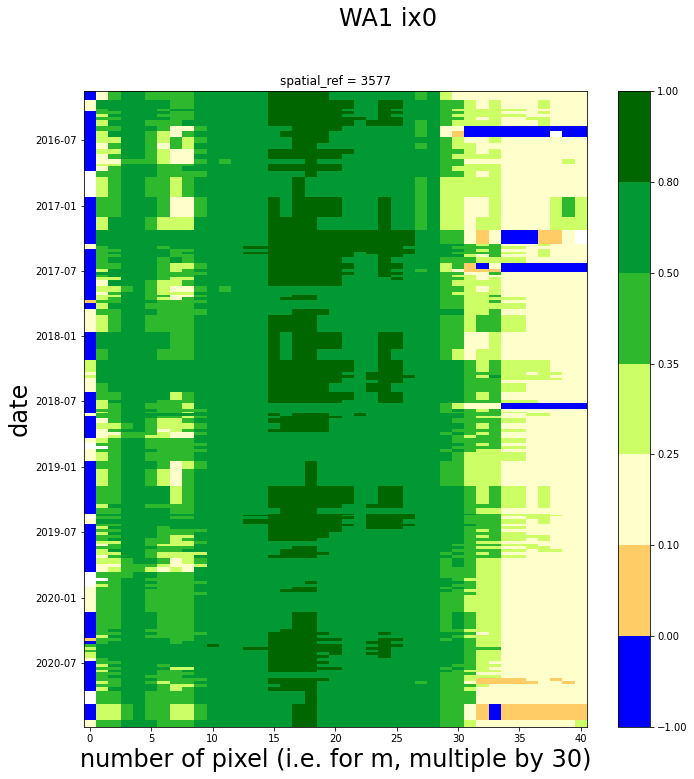

In [36]:
fig = plt.figure(figsize=(11.27,11.69))

hov_multi_ndvi_sel.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm, vmin=-1, vmax =1)
# plt.axis([0, hov_multi_ndvi_sel.distance.max(), '2010-01-01' , '2020-01-01'])
matplotlib.rcParams.update({'font.size': 10})

plt.suptitle(shape_name.replace('_',' '), fontsize ='24')

plt.xlabel('number of pixel (i.e. for m, multiple by 30)', fontsize ='24')
plt.ylabel('date', fontsize ='24')


#save plot to file
plt.savefig('{}{}_HovPlot_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight', dpi=300)
plt.show()